<a href="https://colab.research.google.com/github/MehrdadJalali-AI/BlackHole/blob/main/PLots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

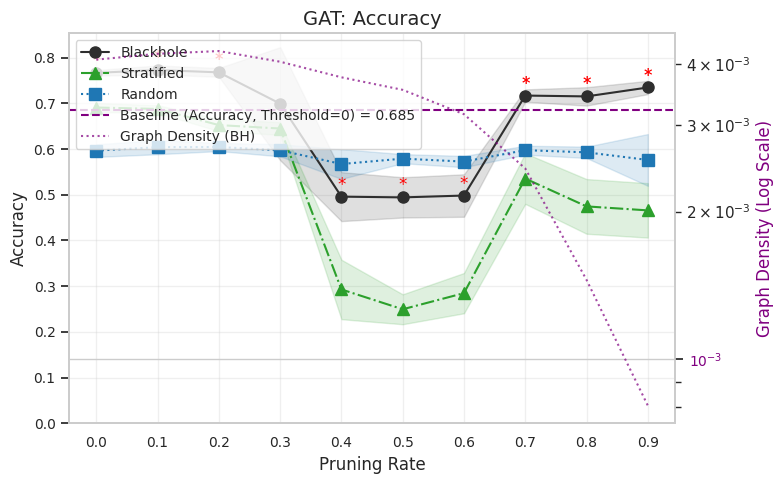

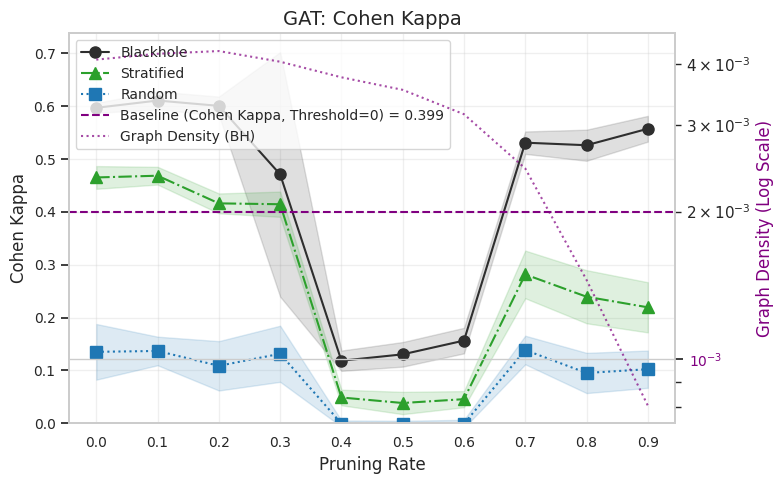

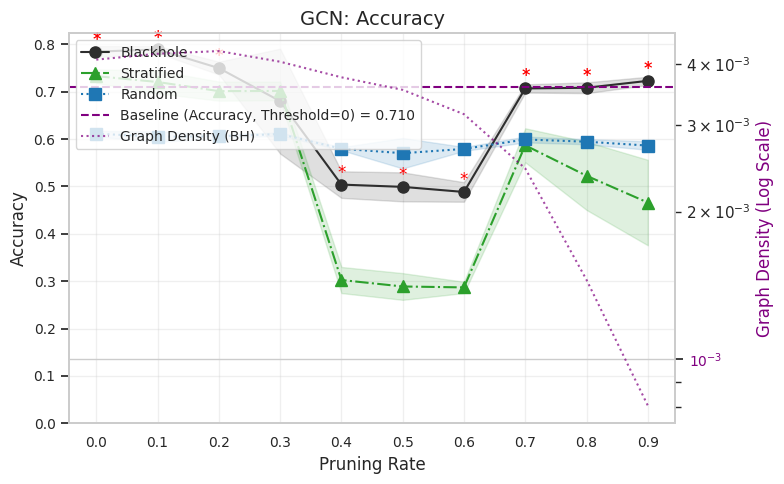

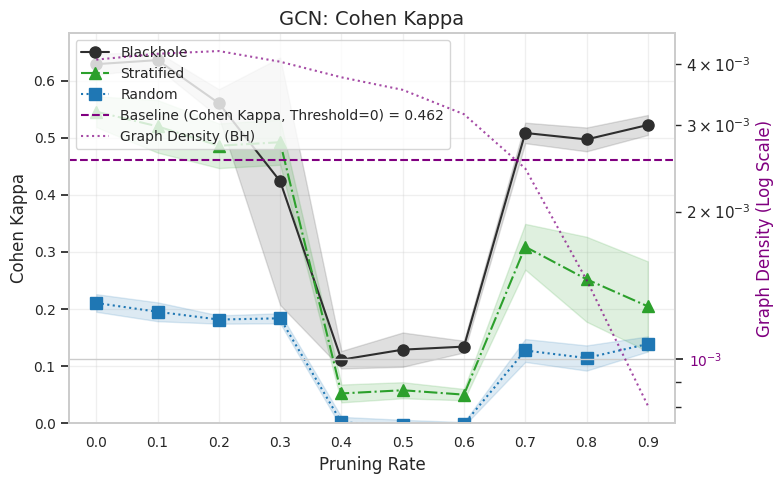

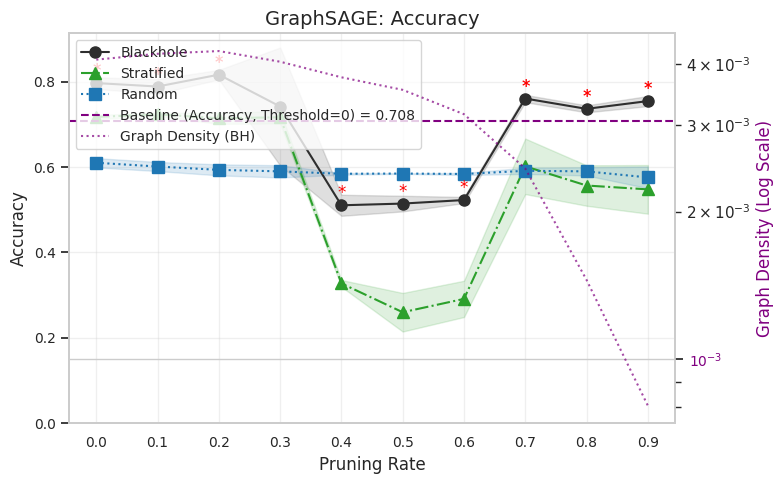

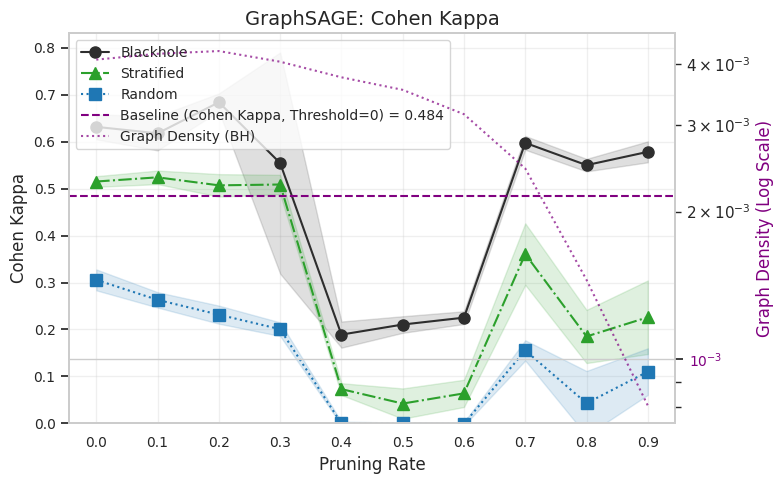

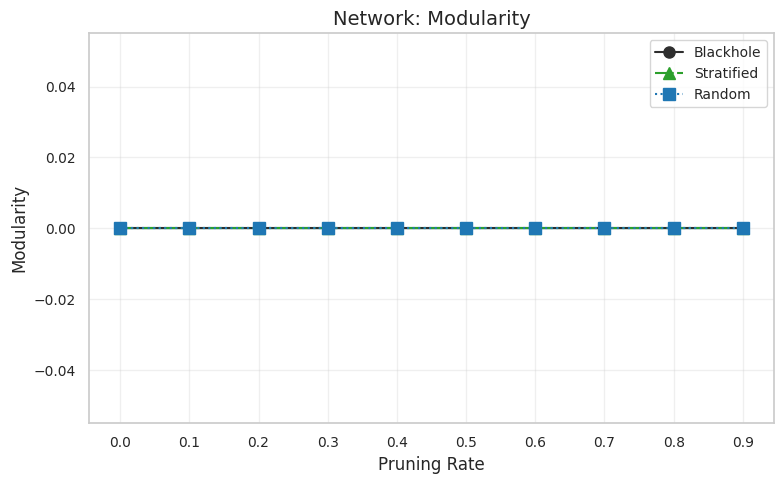

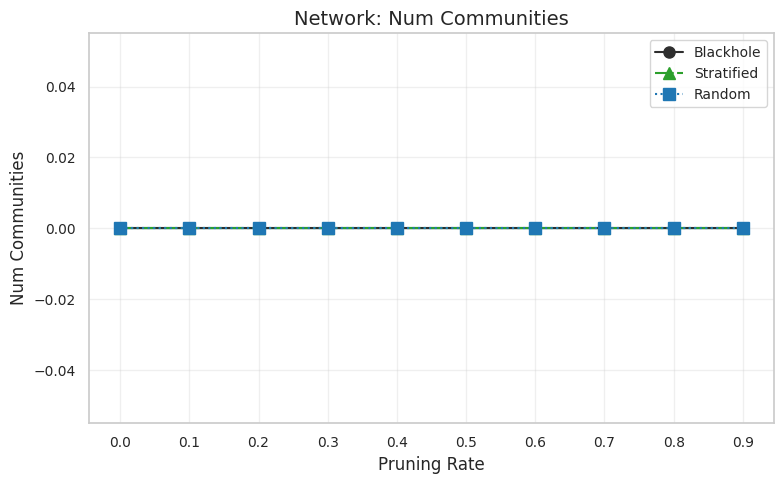

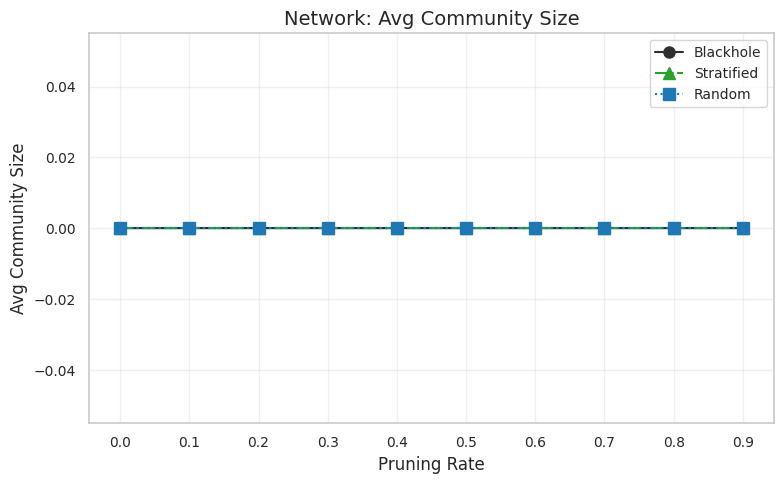

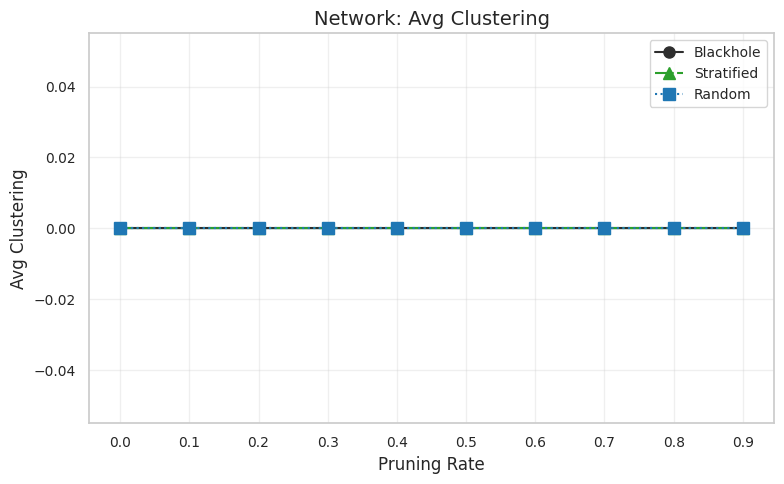

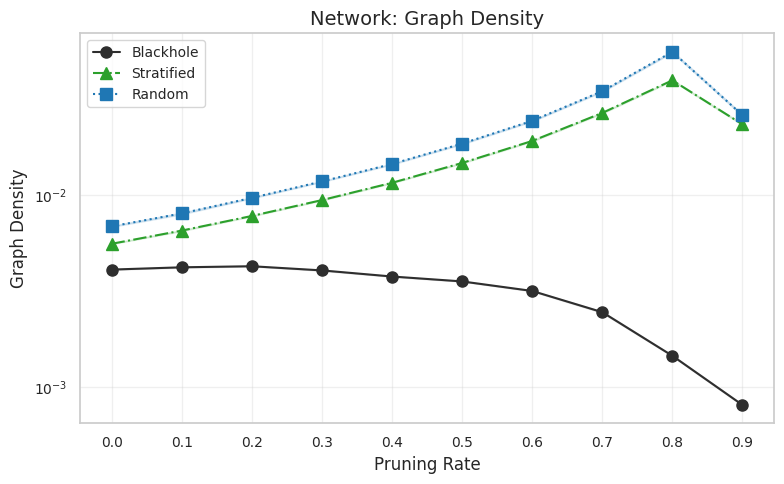

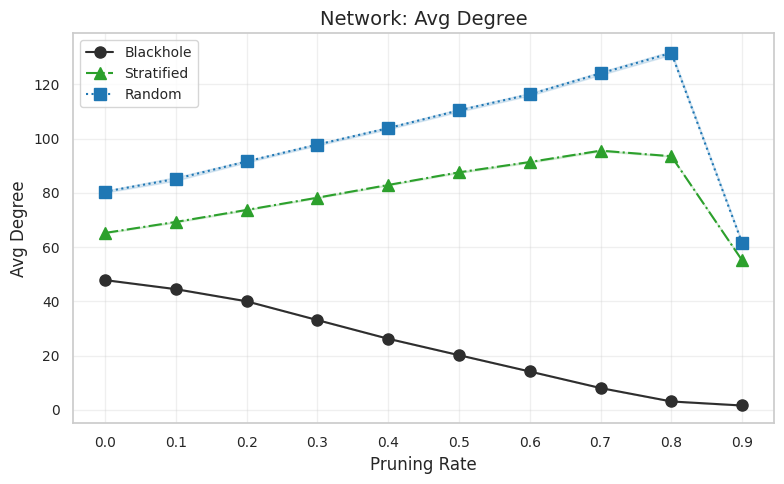

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                     Accuracy_Mean                     Accuracy_sem            \
Model                          GAT       GCN GraphSAGE          GAT       GCN   
Threshold Method                                                                
0.0       blackhole       0.766892  0.784656  0.796534     0.006216  0.011789   
          random          0.596665  0.611378  0.609961     0.013737  0.005945   
          stratified      0.691042  0.732890  0.717197     0.009763  0.014150   
0.1       blackhole       0.773104  0.789233  0.788470     0.009795  0.007276   
          random          0.604294  0.605057  0.601133     0.015459  0.010949   
          stratified      0.687881  0.720575  0.723300     0.008271  0.023922   
0.2       blackhole       0.767982  0.749891  0.816260     0.009590  0.013518   
          random          0.604621  0.605820  0.593287     0.008867  0.004333   
          stratified      0.652572  0.701286  0.714146

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',
    'stratified': '#2CA02C',
    'random': '#1F77B4'
}
method_styles = {
    'blackhole': '-',
    'stratified': '-.',
    'random': ':'
}
method_markers = {
    'blackhole': 'o',
    'stratified': '^',
    'random': 's'
}

# Load data
df = pd.read_csv('results_aggregated.csv')

# Calculate SEM
df['Accuracy_sem'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_sem'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Metrics
performance_metrics = [
    ('Accuracy_Mean', 'Accuracy_sem'),
    ('Cohen_Kappa_Mean', 'Cohen_Kappa_sem')
]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std')
]

models = df['Model'].unique()
threshold_values = sorted(df['Threshold'].unique())

# Font sizes
label_fontsize = 12
tick_fontsize = 10
title_fontsize = 14
legend_fontsize = 10

# Check significance
def is_significant(mean1, sem1, mean2, sem2):
    return mean1 - sem1 > mean2 + sem2

# Plotting function (now includes all methods)
def plot_comparison(subset, metric, std_metric, title_prefix):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean'] else None

    methods = ['blackhole', 'stratified', 'random']
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Threshold')
        if method_data.empty:
            continue
        ax.plot(method_data['Threshold'], method_data[metric],
                label=f'{method.title()}',
                color=method_colors[method], linestyle=method_styles[method],
                marker=method_markers[method], markersize=8)
        ax.fill_between(method_data['Threshold'],
                        method_data[metric] - method_data[std_metric],
                        method_data[metric] + method_data[std_metric],
                        alpha=0.15, color=method_colors[method])

    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        ax.set_ylim(bottom=0)
        density_data = subset[subset['Method'] == 'blackhole'].sort_values('Threshold')
        ax2.plot(density_data['Threshold'], density_data['Graph_Density_Mean'],
                 color='purple', linestyle=':', label='Graph Density (BH)', alpha=0.7)
        ax2.set_yscale('log')
        ax2.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize, color='purple')
        ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    if metric == 'Accuracy_Mean':
        for method in ['stratified', 'random']:
            for thresh in threshold_values:
                bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Threshold'] == thresh)]
                other_data = subset[(subset['Method'] == method) & (subset['Threshold'] == thresh)]
                if not (bh_data.empty or other_data.empty):
                    bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_sem'].values[0]
                    other_acc, other_sem = other_data['Accuracy_Mean'].values[0], other_data['Accuracy_sem'].values[0]
                    if is_significant(bh_acc, bh_sem, other_acc, other_sem):
                        ax.annotate('*', xy=(thresh, bh_acc), xytext=(0, 5),
                                    textcoords='offset points', ha='center', color='red', fontsize=12)

    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name}', fontsize=title_fontsize)
    ax.set_xlabel('Pruning Rate', fontsize=label_fontsize)
    ax.set_ylabel(metric_name, fontsize=label_fontsize)
    ax.set_xticks(threshold_values)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    if metric == 'Graph_Density_Mean':
        ax.set_yscale('log')

    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        baseline = subset[subset['Threshold'] == 0.0][metric].mean()
        ax.axhline(y=baseline, color='purple', linestyle='--',
                   label=f'Baseline ({metric_name}, Threshold=0) = {baseline:.3f}')

    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    plt.tight_layout()
    plt.show()

# Plot all performance metrics
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_comparison(subset, metric, std_metric, model)

# Plot all network metrics (GAT only)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_comparison(subset, metric, std_metric, 'Network')

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Threshold', 'Method'],
    columns='Model',
    values=['Accuracy_Mean', 'Accuracy_sem', 'Cohen_Kappa_Mean', 'Cohen_Kappa_sem'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (GAT only)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Threshold', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)

# Key Findings: Blackhole outperforming others
print("\nKey Findings:")
bh_outperform = []
for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        for method in ['stratified', 'random']:
            other_data = df[(df['Threshold'] == thresh) & (df['Method'] == method) & (df['Model'] == model)]
            if not (bh_data.empty or other_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_sem'].values[0]
                other_acc, other_sem = other_data['Accuracy_Mean'].values[0], other_data['Accuracy_sem'].values[0]
                if is_significant(bh_acc, bh_sem, other_acc, other_sem):
                    bh_outperform.append((thresh, model, method, bh_acc, other_acc))

if bh_outperform:
    print("Thresholds where Blackhole significantly outperforms others (Accuracy):")
    for thresh, model, method, bh_acc, other_acc in bh_outperform:
        print(f"- Threshold {thresh:.1f}, Model {model}, vs {method.title()}: "
              f"BH = {bh_acc:.4f}, {method.title()} = {other_acc:.4f}")
else:
    print("- No thresholds where Blackhole significantly outperforms others.")

# Max/min distance
distances = []
for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        for method in ['stratified', 'random']:
            other_data = df[(df['Threshold'] == thresh) & (df['Method'] == method) & (df['Model'] == model)]
            if not (bh_data.empty or other_data.empty):
                dist = bh_data['Accuracy_Mean'].values[0] - other_data['Accuracy_Mean'].values[0]
                distances.append((dist, thresh, model, method,
                                  bh_data['Accuracy_Mean'].values[0],
                                  other_data['Accuracy_Mean'].values[0]))

max_dist = max(distances, key=lambda x: x[0])
min_dist = min(distances, key=lambda x: x[0])

print(f"\nMaximum Distance: {max_dist[0]:.4f} at Threshold {max_dist[1]:.1f}, Model {max_dist[2]}, vs {max_dist[3].title()} "
      f"(BH = {max_dist[4]:.4f}, {max_dist[3].title()} = {max_dist[5]:.4f})")
print(f"Minimum Distance: {min_dist[0]:.4f} at Threshold {min_dist[1]:.1f}, Model {min_dist[2]}, vs {min_dist[3].title()} "
      f"(BH = {min_dist[4]:.4f}, {min_dist[3].title()} = {min_dist[5]:.4f})")

# Highest accuracy
max_acc_row = df.loc[df['Accuracy_Mean'].idxmax()]
print(f"\nHighest Accuracy: {max_acc_row['Accuracy_Mean']:.4f} by {max_acc_row['Model']} "
      f"({max_acc_row['Method']}) at Threshold {max_acc_row['Threshold']:.1f}, "
      f"with Graph Density = {max_acc_row['Graph_Density_Mean']:.6f}")


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load and filter data
df = pd.read_csv('results_aggregated.csv')
df = df[df['Method'].isin(['blackhole', 'stratified'])]
df['Accuracy_sem'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_sem'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Define visual styles
sns.set(style="whitegrid", context="notebook", palette="deep")
method_colors = {'blackhole': '#2E2E2E', 'stratified': '#2CA02C'}
method_styles = {'blackhole': '-', 'stratified': '--'}
method_markers = {'blackhole': 'o', 'stratified': '^'}

# Metrics
performance_metrics = [('Accuracy_Mean', 'Accuracy_sem'), ('Cohen_Kappa_Mean', 'Cohen_Kappa_sem')]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std')
]
threshold_values = sorted(df['Threshold'].unique())
models = df['Model'].unique()

# Ensure output folder exists
output_dir = "plots_bh_vs_stratified"
os.makedirs(output_dir, exist_ok=True)

# Plotting function (no stars, just % improvement, and save)
def plot_and_save(subset, metric, std_metric, title_prefix):
    plt.figure(figsize=(9, 5))
    for method in ['blackhole', 'stratified']:
        method_data = subset[subset['Method'] == method].sort_values('Threshold')
        if method_data.empty:
            continue
        plt.errorbar(method_data['Threshold'], method_data[metric],
                     yerr=method_data[std_metric],
                     label=method.title(),
                     color=method_colors[method],
                     linestyle=method_styles[method],
                     marker=method_markers[method],
                     capsize=4, markersize=6)

    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        bh_data = subset[subset['Method'] == 'blackhole'].set_index('Threshold')
        strat_data = subset[subset['Method'] == 'stratified'].set_index('Threshold')
        for thresh in threshold_values:
            if thresh in bh_data.index and thresh in strat_data.index:
                bh_val = bh_data.loc[thresh, metric]
                strat_val = strat_data.loc[thresh, metric]
                if strat_val > 0:
                    pct_improve = 100 * (bh_val - strat_val) / strat_val
                    plt.annotate(f"{pct_improve:.1f}%", (thresh, bh_val),
                                 textcoords="offset points", xytext=(0, -15),
                                 ha='center', fontsize=9, color='black')

        # Draw baseline from threshold 0.0
        baseline = strat_data.loc[0.0, metric]
        plt.axhline(y=baseline, color='gray', linestyle=':', label=f'Baseline (0.0) = {baseline:.3f}')

    # Title and save
    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    plt.title(f'{title_prefix}: {metric_name}', fontsize=14)
    plt.xlabel('Pruning Rate', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(threshold_values)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=10)
    plt.tight_layout()

    filename = f"{output_dir}/{title_prefix}_{metric_name.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300)
    plt.close()

# Plot and save performance metrics
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_and_save(subset, metric, std_metric, model)

# Plot and save network metrics (GAT only)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_and_save(subset, metric, std_metric, 'Network')


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load and filter data
df = pd.read_csv('results_aggregated.csv')
df = df[df['Method'].isin(['blackhole', 'stratified'])]
df['Accuracy_sem'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_sem'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Define visual styles
sns.set(style="whitegrid", context="notebook", palette="deep")
method_colors = {'blackhole': '#2E2E2E', 'stratified': '#2CA02C'}
method_styles = {'blackhole': '-', 'stratified': '--'}
method_markers = {'blackhole': 'o', 'stratified': '^'}

# Define metrics
performance_metrics = [('Accuracy_Mean', 'Accuracy_sem'), ('Cohen_Kappa_Mean', 'Cohen_Kappa_sem')]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std')
]
threshold_values = sorted(df['Threshold'].unique())
models = df['Model'].unique()

# Ensure output folder exists
output_dir = "plots_bh_vs_stratified"
os.makedirs(output_dir, exist_ok=True)

# Clean plotting function (NO stars, NO % labels)
def plot_and_save_clean(subset, metric, std_metric, title_prefix):
    plt.figure(figsize=(9, 5))
    for method in ['blackhole', 'stratified']:
        method_data = subset[subset['Method'] == method].sort_values('Threshold')
        if method_data.empty:
            continue
        plt.errorbar(method_data['Threshold'], method_data[metric],
                     yerr=method_data[std_metric],
                     label=method.title(),
                     color=method_colors[method],
                     linestyle=method_styles[method],
                     marker=method_markers[method],
                     capsize=4, markersize=6)

    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        strat_data = subset[subset['Method'] == 'stratified'].set_index('Threshold')
        if 0.0 in strat_data.index:
            baseline = strat_data.loc[0.0, metric]
            plt.axhline(y=baseline, color='gray', linestyle=':', label=f'Baseline (0.0) = {baseline:.3f}')

    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    plt.title(f'{title_prefix}: {metric_name}', fontsize=14)
    plt.xlabel('Pruning Rate', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(threshold_values)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=10)
    plt.tight_layout()

    filename = f"{output_dir}/{title_prefix}_{metric_name.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300)
    plt.close()

# Plot and save performance metrics
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_and_save_clean(subset, metric, std_metric, model)

# Plot and save network metrics (GAT only)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_and_save_clean(subset, metric, std_metric, 'Network')


In [26]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import ast
from tqdm import tqdm

# Configure logging
logging.basicConfig(
    filename='confusion_matrices_plot.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def plot_confusion_matrix(cm, threshold, model, accuracy, kappa, output_dir, class_names):
    """Plot and save a confusion matrix as a heatmap with percentages using a single color theme for cells."""
    try:
        # Normalize confusion matrix by rows (true class totals)
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_normalized = (cm / row_sums * 100).round(2)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', vmin=0, vmax=100, cbar_kws={'label': 'Percentage (%)'}, xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{model} at Threshold {threshold}', fontweight='bold')
        plt.xlabel('Predicted', fontweight='bold')
        plt.ylabel('Actual', fontweight='bold')
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f'confusion_matrix_blackhole_run0_{model}_threshold_{threshold:.2f}.png')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
        logger.info(f"Saved confusion matrix plot to {output_file}")
    except Exception as e:
        logger.error(f"Failed to plot confusion matrix for threshold={threshold:.2f}, model={model}: {e}")

def main():
    input_file = 'final_results.csv'
    output_dir = 'confusion_matrices_plots'
    thresholds = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
    models = ['GAT', 'GCN', 'GraphSAGE']
    class_names = ['nonporous', 'small', 'medium', 'large']  # Based on MOFCSD.csv categories

    # Load CSV
    try:
        df = pd.read_csv(input_file)
        logger.info(f"Loaded {input_file} with {len(df)} rows")
    except Exception as e:
        logger.error(f"Failed to load {input_file}: {e}")
        return

    # Filter for blackhole, run=0, and GNN models
    df_filtered = df[(df['Method'] == 'blackhole') & (df['Run'] == 0) & (df['Model'].isin(models))]
    df_filtered = df_filtered.drop_duplicates(subset=['Threshold', 'Model', 'Run'])
    logger.info(f"Filtered to {len(df_filtered)} rows for Method=blackhole, Run=0, Models={models}")

    # Total iterations for progress bar
    total_iterations = len(thresholds) * len(models)

    # Plot confusion matrices
    with tqdm(total=total_iterations, desc="Plotting Confusion Matrices", position=0) as pbar:
        for threshold in thresholds:
            for model in models:
                # Find matching row
                row = df_filtered[(df_filtered['Threshold'] == threshold) & (df_filtered['Model'] == model)]

                if row.empty:
                    logger.warning(f"No data for threshold={threshold:.2f}, model={model}")
                    pbar.update(1)
                    continue

                try:
                    # Extract confusion matrix, accuracy, and kappa
                    cm_str = row['Confusion_Matrix'].iloc[0]
                    cm = np.array(ast.literal_eval(cm_str))
                    accuracy = row['Accuracy'].iloc[0]
                    kappa = row['Cohen_Kappa'].iloc[0]

                    # Validate confusion matrix shape
                    if cm.shape != (4, 4):
                        logger.error(f"Invalid confusion matrix shape {cm.shape} for threshold={threshold:.2f}, model={model}")
                        pbar.update(1)
                        continue

                    # Plot confusion matrix
                    plot_confusion_matrix(cm, threshold, model, accuracy, kappa, output_dir, class_names)
                except Exception as e:
                    logger.error(f"Failed to process threshold={threshold:.2f}, model={model}: {e}")

                pbar.update(1)

    logger.info(f"Completed plotting. Check {output_dir} for PNG files.")

if __name__ == "__main__":
    main()

Plotting Confusion Matrices: 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Paths and configuration
folder_path = "BH_Datasets"
output_folder = "Metal_Distribution_Plots"
os.makedirs(output_folder, exist_ok=True)

thresholds = ['0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90']
file_prefix = "remaining_node_features_t"
file_suffix = "_r0.csv"
original_file = os.path.join(folder_path, f"{file_prefix}0.00{file_suffix}")

# Load original dataset
if not os.path.exists(original_file):
    print(f"Original file {original_file} not found.")
    exit()
original_df = pd.read_csv(original_file)

# Identify top 5 metals in the original dataset
top5_metals = original_df['metal'].value_counts().nlargest(5).index.tolist()

# Precompute original metal distribution (normalized)
original_counts = original_df['metal'].value_counts(normalize=True)
original_top5_dist = original_counts[top5_metals]

# Loop through thresholds and create plots
for thresh in thresholds:
    file_name = os.path.join(folder_path, f"{file_prefix}{thresh}{file_suffix}")
    if not os.path.exists(file_name):
        print(f"File {file_name} not found. Skipping threshold {thresh}.")
        continue

    thresh_df = pd.read_csv(file_name)
    label = thresh

    # Count frequencies of top 5 metals in the representative set
    rep_counts = thresh_df['metal'].value_counts(normalize=True)
    rep_top5_dist = rep_counts.reindex(top5_metals).fillna(0)

    # Combine into a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Metal': top5_metals,
        'Original': original_top5_dist.values,
        f'Threshold {label}': rep_top5_dist.values
    }).melt(id_vars='Metal', var_name='Dataset', value_name='Proportion')

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=plot_df, x='Metal', y='Proportion', hue='Dataset',
                palette={'Original': '#4682B4', f'Threshold {label}': 'black'})

    #plt.title(f'Metal Distribution: Original vs. Threshold {label}', fontsize=14)
    plt.xlabel('Metal Atom', fontsize=12)
    plt.ylabel('Proportion of MOFs', fontsize=12)
    plt.ylim(0, 0.2)

    plt.legend(title='')
    plt.tight_layout()

    # Save
    output_path = os.path.join(output_folder, f"metal_dist_thresh_{label.replace('.', '')}.jpg")
    plt.savefig(output_path, dpi=300)
    plt.close()

    print(f"Saved plot: {output_path}")

print("All metal distribution plots saved.")


Saved plot: Metal_Distribution_Plots/metal_dist_thresh_010.jpg
Saved plot: Metal_Distribution_Plots/metal_dist_thresh_020.jpg
Saved plot: Metal_Distribution_Plots/metal_dist_thresh_030.jpg
Saved plot: Metal_Distribution_Plots/metal_dist_thresh_040.jpg
Saved plot: Metal_Distribution_Plots/metal_dist_thresh_050.jpg
Saved plot: Metal_Distribution_Plots/metal_dist_thresh_060.jpg
Saved plot: Metal_Distribution_Plots/metal_dist_thresh_070.jpg
Saved plot: Metal_Distribution_Plots/metal_dist_thresh_080.jpg
Saved plot: Metal_Distribution_Plots/metal_dist_thresh_090.jpg
All metal distribution plots saved.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pubchempy import get_compounds
from collections import defaultdict

# Setup
folder_path = "BH_Datasets"
output_folder = "Linker_Distribution_Plots"
os.makedirs(output_folder, exist_ok=True)

thresholds = ['0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90']
file_prefix = "remaining_node_features_t"
file_suffix = "_r0.csv"
original_file = os.path.join(folder_path, f"{file_prefix}0.00{file_suffix}")

# Load original dataset
original_df = pd.read_csv(original_file)

# Get top 5 most common SMILES strings
top5_smiles = original_df['linker SMILES'].value_counts().nlargest(5).index.tolist()

# Convert SMILES → IUPAC name via PubChem
def smiles_to_iupac(smiles):
    try:
        compounds = get_compounds(smiles, namespace='smiles')
        return compounds[0].iupac_name if compounds and compounds[0].iupac_name else "Unrecognized"
    except:
        return "Unrecognized"

# Build map once
smiles_name_map = {smi: smiles_to_iupac(smi) for smi in top5_smiles}

# Get original distribution
original_counts = original_df['linker SMILES'].value_counts(normalize=True)
original_top5_dist = original_counts[top5_smiles]

# Loop through thresholds
for thresh in thresholds:
    file_path = os.path.join(folder_path, f"{file_prefix}{thresh}{file_suffix}")
    if not os.path.exists(file_path):
        continue

    df = pd.read_csv(file_path)
    label = thresh

    # Get representative distribution
    rep_counts = df['linker SMILES'].value_counts(normalize=True)
    rep_top5_dist = rep_counts.reindex(top5_smiles).fillna(0)

    # Prepare data for plotting
    plot_df = pd.DataFrame({
        'Linker': [smiles_name_map[smi] for smi in top5_smiles],
        'Original': original_top5_dist.values,
        f'Threshold {label}': rep_top5_dist.values
    }).melt(id_vars='Linker', var_name='Dataset', value_name='Proportion')

    # Plot
    plt.figure(figsize=(9, 6))
    sns.barplot(data=plot_df, y='Linker', x='Proportion', hue='Dataset',
    palette={'Original': '#4682B4', f'Threshold {label}': 'black'})
    plt.ylabel('Linker (IUPAC Name)', fontsize=12)
    plt.xlabel('Proportion of MOFs', fontsize=12)
    plt.yticks(rotation=0)

    # Save
    output_path = os.path.join(output_folder, f"linker_dist_thresh_{label.replace('.', '')}.jpg")
    plt.savefig(output_path, dpi=300)
    plt.close()

    print(f"Saved: {output_path}")


Saved: Linker_Distribution_Plots/linker_dist_thresh_010.jpg
Saved: Linker_Distribution_Plots/linker_dist_thresh_020.jpg
Saved: Linker_Distribution_Plots/linker_dist_thresh_030.jpg
Saved: Linker_Distribution_Plots/linker_dist_thresh_040.jpg
Saved: Linker_Distribution_Plots/linker_dist_thresh_050.jpg
Saved: Linker_Distribution_Plots/linker_dist_thresh_060.jpg
Saved: Linker_Distribution_Plots/linker_dist_thresh_070.jpg
Saved: Linker_Distribution_Plots/linker_dist_thresh_080.jpg
Saved: Linker_Distribution_Plots/linker_dist_thresh_090.jpg


In [ ]:
pip install pubchempy


  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13818 sha256=3a9dd5ddfa8523d25b9255012666793ea8c2df4060f5d33b4ffcb03439cd99ad
  Stored in directory: /root/.cache/pip/wheels/8b/e3/6c/3385b2db08b0985a87f5b117f98d0cb61a3ae3ca3bcbbd8307
Successfully built pubchempy
